# Comparing Pronto with Fremont


- [Spokane Street Bridge Data](https://data.seattle.gov/Transportation/Spokane-St-Bridge-Counter/upms-nr8w)

- [Fremont Bridge Data](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k)

- [Pronto Data](https://www.prontocycleshare.com/datachallenge)

In [1]:
import os

# Download Pronto Data
if not os.path.exists('open_data_year_one.zip'):
    !curl -O https://s3.amazonaws.com/pronto-data/open_data_year_one.zip
    !unzip open_data_year_one.zip

# Download Spokane St. Bridge data
if not os.path.exists('SpokaneBridge.csv'):
    !curl -o SpokaneBridge.csv https://data.seattle.gov/api/views/upms-nr8w/rows.csv?accessType=DOWNLOAD

# Download Fremont Bridge data
if not os.path.exists('FremontBridge.csv'):
    !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [3]:
FB_trips = pd.read_csv('FremontBridge.csv', index_col='Date',
                       parse_dates=['Date'])
FB_by_date = FB_trips.groupby(FB_trips.index.date.astype('datetime64')).sum()
FB_by_date['Fremont Bridge Total'] = FB_by_date.sum(1)
FB_by_date.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk,Fremont Bridge Total
2012-10-03,1760,1761,3521
2012-10-04,1708,1767,3475
2012-10-05,1558,1590,3148
2012-10-06,1080,926,2006
2012-10-07,1191,951,2142


In [4]:
SS_trips = pd.read_csv('SpokaneBridge.csv', index_col='Date',
                       parse_dates=['Date'])
SS_by_date = SS_trips.groupby(SS_trips.index.date.astype('datetime64')).sum()
SS_by_date = SS_by_date.iloc[:, [1, 2, 0]]
SS_by_date.columns = ['Spokane St. Bridge West',
                      'Spokane St. Bridge East',
                      'Spokane St. Bridge Total']
SS_by_date.head()

,Spokane St. Bridge West,Spokane St. Bridge East,Spokane St. Bridge Total
2014-01-01,121,125,246
2014-01-02,233,263,496
2014-01-03,238,272,510
2014-01-04,190,230,420
2014-01-05,144,145,289


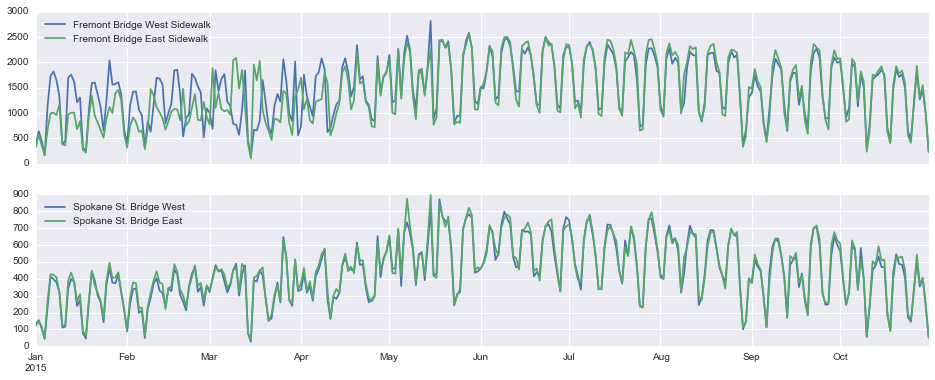

In [5]:
fig, ax = plt.subplots(2, figsize=(16, 6), sharex=True);
FB_by_date['2015'].iloc[:, :2].plot(ax=ax[0]);
SS_by_date['2015'].iloc[:, :2].plot(ax=ax[1]);

In [6]:
PCS_trips = pd.read_csv('2015_trip_data.csv',
                        parse_dates=['starttime', 'stoptime'],
                        infer_datetime_format=True)

# Find the start date
ind = pd.DatetimeIndex(PCS_trips.starttime)
PCS_by_date = PCS_trips.pivot_table('trip_id', aggfunc='count',
                                    index=ind.date.astype('datetime64'),
                                    columns='usertype')
PCS_by_date.columns.name = None
PCS_by_date['Pronto Total'] = PCS_by_date.sum(1)
PCS_by_date.head()

,Annual Member,Short-Term Pass Holder,Pronto Total
2014-10-13,284,125,409
2014-10-14,268,223,491
2014-10-15,212,101,313
2014-10-16,268,127,395
2014-10-17,195,99,294


In [7]:
joined = PCS_by_date.join(FB_by_date).join(SS_by_date)
joined.head()

,Annual Member,Short-Term Pass Holder,Pronto Total,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk,Fremont Bridge Total,Spokane St. Bridge West,Spokane St. Bridge East,Spokane St. Bridge Total
2014-10-13,284,125,409,1967,1388,3355,437,465,902
2014-10-14,268,223,491,1647,1550,3197,413,423,836
2014-10-15,212,101,313,1415,1140,2555,305,372,677
2014-10-16,268,127,395,2126,1503,3629,494,518,1012
2014-10-17,195,99,294,1236,973,2209,273,277,550


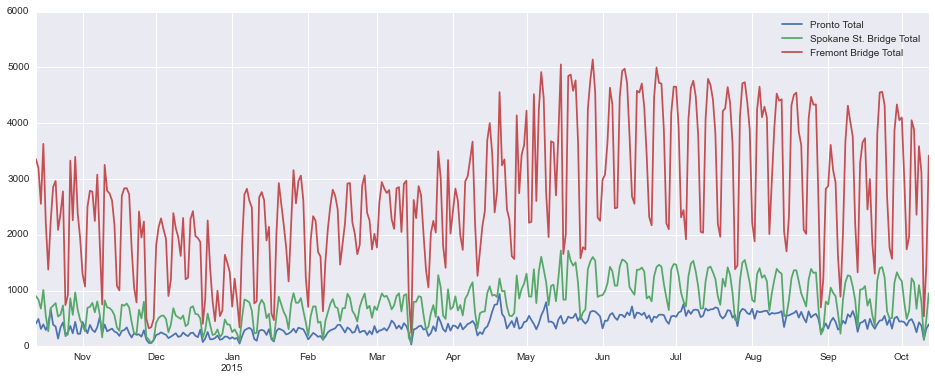

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))
joined[['Pronto Total', 'Spokane St. Bridge Total', 'Fremont Bridge Total']].plot(ax=ax);

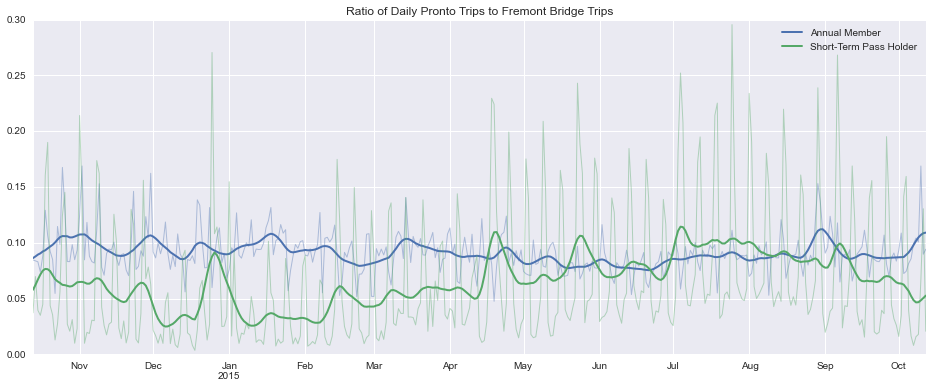

In [9]:
fig, ax = plt.subplots(figsize=(16, 6), sharex=True, sharey=True)
cols = ['Annual Member', 'Short-Term Pass Holder']

for i, col in enumerate(cols):
    ratio = (joined[col] / joined['Fremont Bridge Total'])
    ratio.plot(ax=ax, lw=1, alpha=0.4)
    smoothed = pd.rolling_window(ratio, 14, win_type='gaussian', std=3, center=True, min_periods=7)
    smoothed.plot(ax=ax, color=ax.lines[-1].get_color(), lw=2)
plt.legend(ax.lines[1::2], cols)
plt.title('Ratio of Daily Pronto Trips to Fremont Bridge Trips');

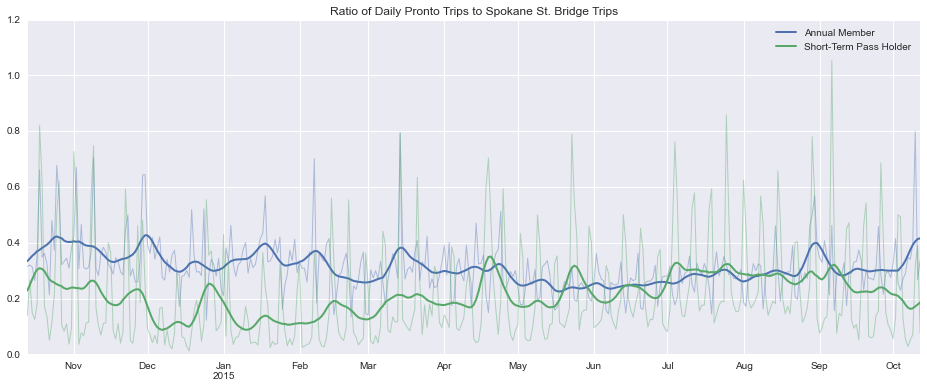

In [10]:
fig, ax = plt.subplots(figsize=(16, 6), sharex=True, sharey=True)
cols = ['Annual Member', 'Short-Term Pass Holder']

for i, col in enumerate(cols):
    ratio = (joined[col] / joined['Spokane St. Bridge Total'])
    ratio.plot(ax=ax, lw=1, alpha=0.4)
    smoothed = pd.rolling_window(ratio, 14, win_type='gaussian', std=3, center=True, min_periods=7)
    smoothed.plot(ax=ax, color=ax.lines[-1].get_color(), lw=2)
plt.legend(ax.lines[1::2], cols)
plt.title('Ratio of Daily Pronto Trips to Spokane St. Bridge Trips');